<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем необходимые библиотеки.

In [1]:
!pip install -Uq scikit-learn

In [2]:
!pip install phik -q

In [3]:
pip install lightgbm -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, ElasticNet
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error

from phik.report import correlation_report, plot_correlation_matrix


import warnings
warnings.filterwarnings('ignore')

Загрузим данные для анализа и прогнозирования.

In [5]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Выведем первые пять строк для понимания структуры данных.

In [6]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Выведем общую информацию о датасете.

In [7]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В данных нет пропусков.

Отсортируем данные в хронологическом порядке.

In [8]:
taxi.sort_index(inplace=True)

Произведем ресемплирование данных по часу. Ведь мы хотим делать прогнозы именно для интервала в час. Для каждого часа посчитаем суммарное количество заказанных такси.

In [9]:
taxi = taxi.resample('1H').sum()

In [10]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Изучим распределение целевой переменной.

In [11]:
taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


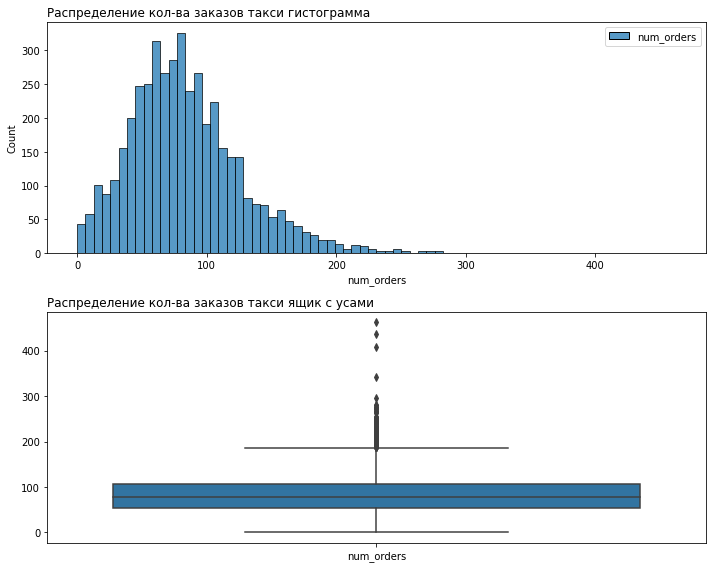

In [12]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
sns.histplot(data=taxi)
plt.xlabel('num_orders')
plt.title('Распределение кол-ва заказов такси гистограмма', loc='left')
plt.subplot(212)
sns.boxplot(data=taxi)
plt.title('Распределение кол-ва заказов такси ящик с усами', loc='left')
plt.tight_layout()

**Промежуточный вывод**

Импортировали необходимые билиотеки для проекта. Загрузили данные, при загрузке сразу же указали дату как индекс датафрейм и использовали parse_dates. Отсортировали данные в хронологическом порядке, произвели ресемплирование по часу с подсчетом суммарного количества заказанных машин такси. Изучили распределение целевой переменной. Увидели по графикам, что в основном заказывается от 50 до 100 машин. Но есть и нулевые значения, а также значения выше 400. Мы не будем это считать аномалиями, так как действительно есть периоды в сутках, когда машины не заказываются, а есть наоборот редкие пики (например, перед Новым Годом, перед 1 сентября, 8 марта, и в это время цены взлетают...). В любом случае мы не будем делать никаких манипуляций с целевой переменной.

## Анализ

Проверим за какой промежуток времени мы имеем данные.

In [13]:
print('Начало периода: ', taxi.index[0], '      ', 'Конец периода: ', taxi.index[-1])

Начало периода:  2018-03-01 00:00:00        Конец периода:  2018-08-31 23:00:00


Итого имеем данные за период с 1 марта 2018 года по 31 августа 2018 года. К сожалению, данные предоставлены не за весь год, так как в течение года есть несколько сезонностей. 

Построим график заказа такси.

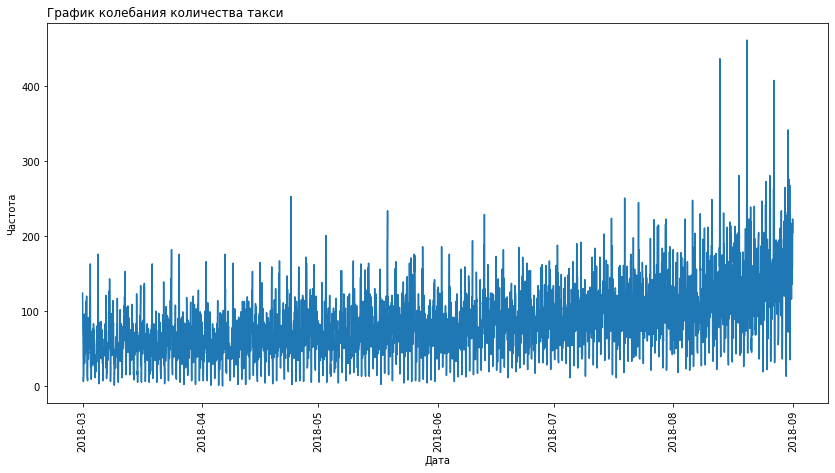

In [14]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=taxi, x=taxi.index, y=taxi['num_orders'])
plt.title('График колебания количества такси', loc = 'left') 
plt.xlabel('Дата') 
plt.ylabel('Частота') 
plt.xticks(rotation=90)
plt.show()

Видим постоянные колебания. В таком виде график не информативен. Добавим в данные скользящее среднее. Сделаем окна:
- 24 часа (чтобы понять недельный тренд)
- 12 часов (чтобы понять тренд ночь-день)
- 8 часов (чтобы понять тренд ночь-утро-вечер)

И далее построим графики.

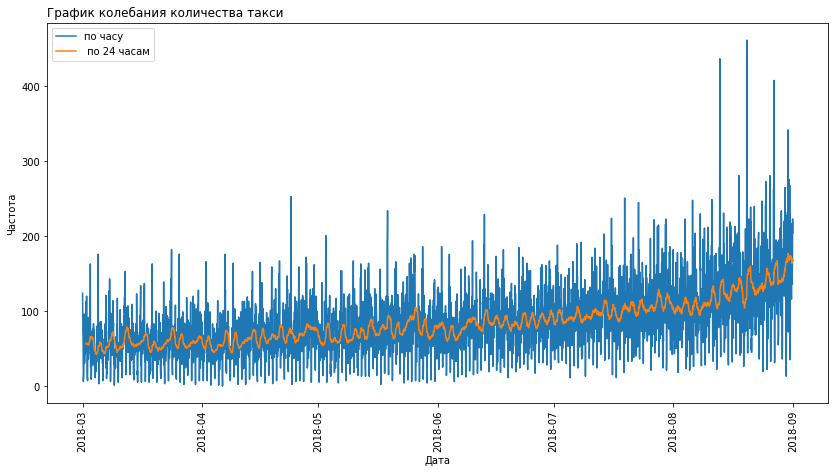

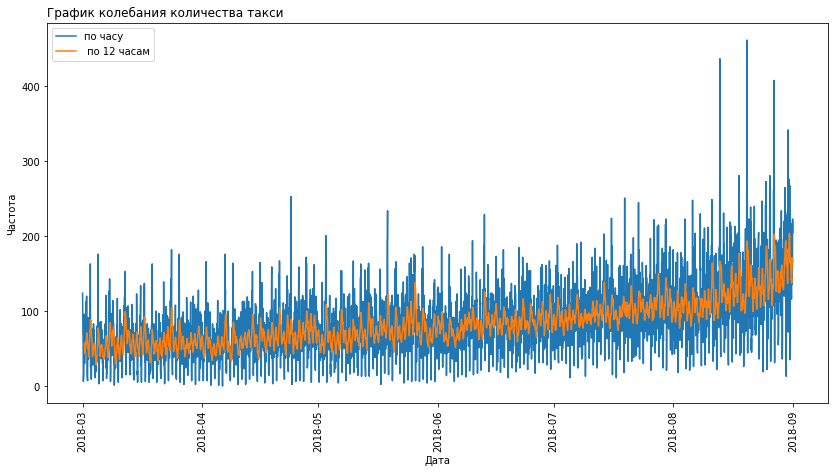

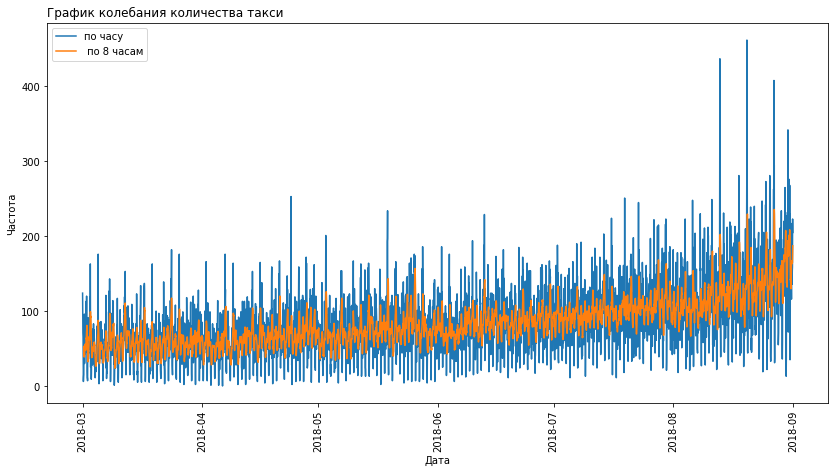

In [15]:
for i in [24, 12, 8]:
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=taxi, x=taxi.index, y=taxi['num_orders'], label='по часу')
    sns.lineplot(data=taxi, x=taxi.index, y=taxi['num_orders'].rolling(i).mean(), label=f' по {i} часам')
    plt.title('График колебания количества такси', loc = 'left') 
    plt.xlabel('Дата') 
    plt.ylabel('Частота') 
    plt.xticks(rotation=90)
    plt.show()

По графикам делаем вывод, что в целом тренд идет на повышение заказов такси - постепенный рост от марта к августу. Но в целом повышение не такое и ярко выраженное, поэтому можно сделать допущение, что временной ряд по представленному промежутку практически стационарен. Также видим, что в целом по дням нет таких сильных колебаний, как при интервалах в 12 и 8 часов. Поэтому можем сделать вывод, что количество заказов сильно зависит от времени суток и менее зависит, но тем не менее зависит, от дня.

Также по графикам видим аномалии, которые мы заметили на графиках распределения целевой переменной. Всплески в конце августа. Похоже на реальность. Конец августа - перед началом учебного года семьи возвращаются домой, а затем едут за школьными покупками.

С помощью библиотеки statsmodels изучим тренд и сезонность (хотя по графикам выше уже видно, что тренд идет на мягкое повышение количества, а сезонности не особо наблюдается).

In [16]:
decomposed = seasonal_decompose(taxi['num_orders'])

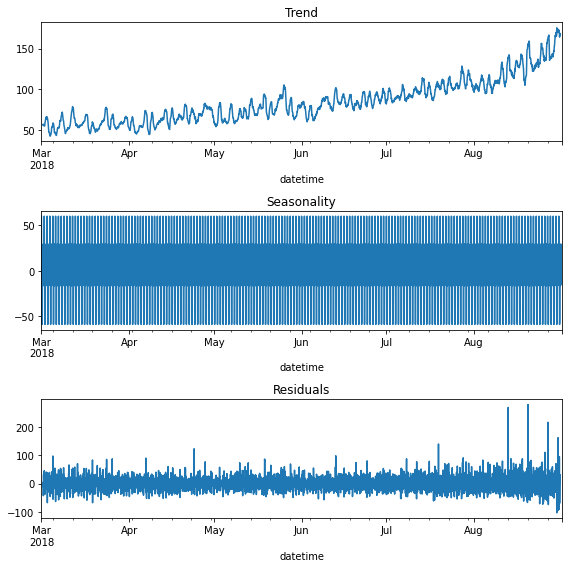

In [17]:

plt.figure(figsize=(8, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Графики подтвердили наши прежние выводы.

Проверим дополнительно внутрисуточную, недельную, месячную и квартальную сезонность сезонность.

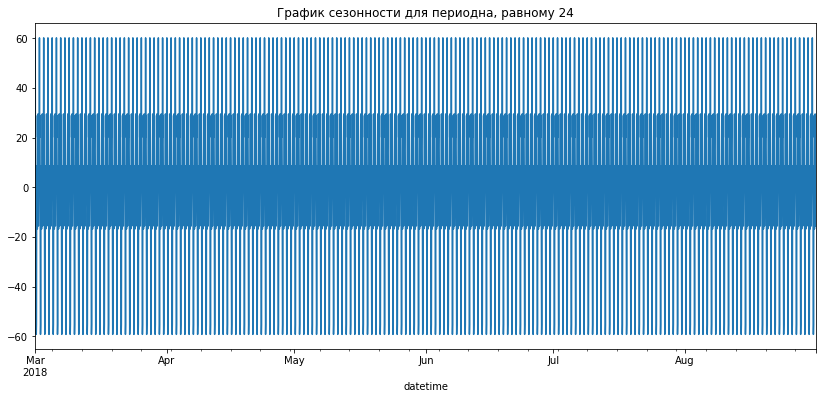

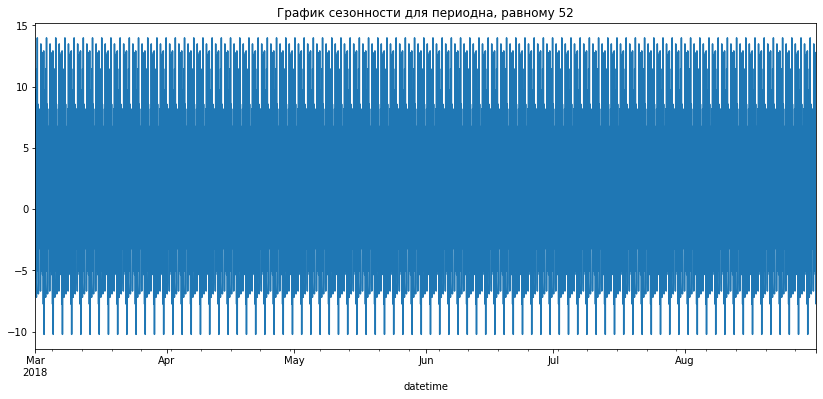

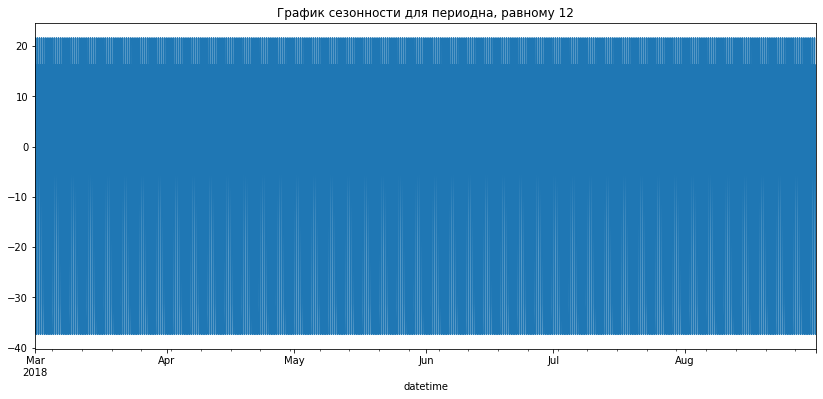

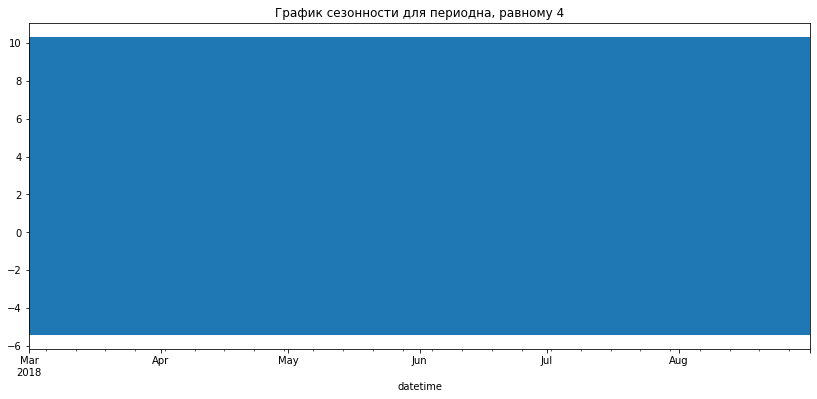

In [36]:
for period in [24, 52, 12, 4]: #24 - внутрисуточная, 52 - внутринедельная, 12 - внутримесячная, 4 - квартальная)
    result = seasonal_decompose(taxi['num_orders'], period=period)
    plt.figure(figsize=(14,6))
    result.seasonal.plot()
    plt.title(f'График сезонности для периодна, равному {period}')
    plt.show()
    


Как видим согласно графиков для декомпозиции с помощью библиотеки statsmodels.tsa.seasonal, сезонность в более компактных промежутках также отсутствует.

И дополнительно, чтобы уже наверняка убедиться в отсутвии сезонности в сутках, неделе, месяце и квартале, построим график заказов, используя датафрейм.

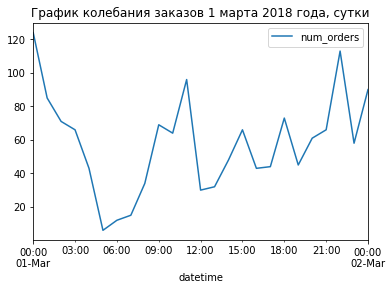

In [54]:
# Для суток
taxi['2018-03-01 00:00:00':'2018-03-02 00:00:00'].plot()
plt.title(f'График колебания заказов 1 марта 2018 года, сутки')
plt.show()

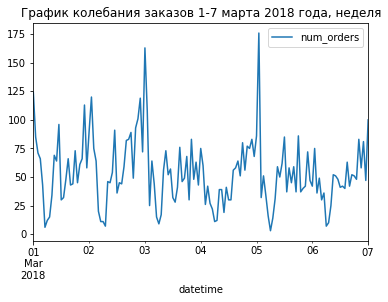

In [55]:
# Для недели
taxi['2018-03-01 00:00:00':'2018-03-07 00:00:00'].plot()
plt.title(f'График колебания заказов 1-7 марта 2018 года, неделя')
plt.show()

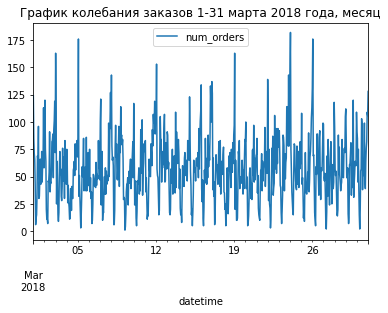

In [56]:
# Для месяца
taxi['2018-03-01 00:00:00':'2018-03-31 00:00:00'].plot()
plt.title(f'График колебания заказов 1-31 марта 2018 года, месяц')
plt.show()

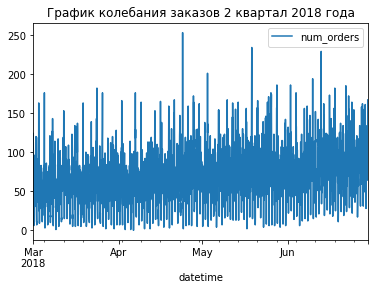

In [58]:
# Для квартала
taxi['2018-03-01 00:00:00':'2018-06-30 00:00:00'].plot()
plt.title(f'График колебания заказов 2 квартал 2018 года')
plt.show()

**Промежуточный вывод**

Предоставлены данные за период с 1 марта 2018 года по 31 августа 2018 года. К сожалению, данные предоставлены не за весь год, так как в течение года есть несколько сезонностей. 

Построили графики колебаний исходных данных с шагом в один час, а затем со скользящим средним по 24, 12 и 8 часам. Из графиков по предоставленным данным за 6 месяцев сделали вывод, что в целом имеется мягкий тренд на повышение количества заказов, сезонности не наблюдается, временной ряд имеет практически стационарную природу - среднее растет, но не ярко выражено, дисперсия практически не изменяется. Есть аномальные всплески.

Чтобы дополнительно проверить сезонность в более компактных промежутках (сутки, неделя, месяц, квартал) построили графики с помощью библиотеки statsmodels.tsa.seasonal, согласно которым ярко выраженной сезонности не обнаружили. И наконец, выбрали случайные промежутки в данных и построили обыкновенные графики колебаний заказов в течение 1 марта 2018, 1-7 марта 2018, март 2018, 2 квартал 2018 года. Касательно суток можно сказать, что все-таки внутрисуточная сезонность есть. Видим спад заказов с полуночи до 6 утра, затем рост с 6 утра до полудня (люди едут на работу), далее снова спад (все работают), далее рост до 21 часа. Но мы не можем делать выводы по одному случайно выбранному дню. В остальных исследуемых промежутках ярко выраженной сезонности нет.


## Обучение

Для прогнозирования создадим дополнительные признаки. Добавим в признаки отстающие значения. Мы помним по графикам, что самые большие колебания были при скользящем в 8 часов, но и при 12 часах они были значительны, что является логичным, ведь по идее в разное время суток заказывается разное время машин. Есть пиковые значения - это утро, есть спокойные периоды - это ночь. Поэтому создадим отстающие значения от 1 до 24 часов, чтобы охватить полностью сутки. 

Также добавим в данные месяц, день недели, число дня. Эти признаки также важны. 
Утром в выходной день заказов гораздо меньше, чем утром в рабочий день. 

Также добавим значение скользящего среднего в размере 12 часов, но со сдвигом один, чтобы в окно не попало текущее значение заказов, и наша модель не подглядела данные.

Создадим функцию для добавления признаков в наши данные.

In [59]:
def new_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [60]:
taxi_copy = new_features(taxi, 24, 12)

In [61]:
taxi_copy.tail()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,163.416667
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,170.916667
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.583333
2018-08-31 22:00:00,223,8,31,4,159.0,154.0,136.0,207.0,217.0,197.0,...,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,164.916667
2018-08-31 23:00:00,205,8,31,4,223.0,159.0,154.0,136.0,207.0,217.0,...,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,167.583333


Разобьем данные на тренировочную и тестовые выборки с учетом хронологии (данные перемешивать нельзя!).

In [62]:
train, test = train_test_split(taxi_copy, shuffle=False, test_size=0.1)

Отбросим пустые значения, поскольку помним, что при подсчете скользящих средних и отстающих признаков возникают пропуски. Сделаем это только для train, поскольку в test по идее не должно возникнуть пропусков, так как данные мы сдвигаем назад.

In [63]:
train = train.dropna()

In [64]:
train.isna().sum()

num_orders      0
month           0
day             0
dayofweek       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
rolling_mean    0
dtype: int64

In [65]:
test.isna().sum()

num_orders      0
month           0
day             0
dayofweek       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
rolling_mean    0
dtype: int64

Проверим индексы выборок, чтобы убедиться, что данные разбились корректно.

In [66]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Данные разбились корректно.

Создадим тренировочную и тестовую выборки с входящими признаками и целевой переменной. 


Целевая переменная - количество заказов, которое мы предскажем по входящим признакам.

In [67]:
X_train = train.drop('num_orders', axis=1)

In [68]:
y_train = train['num_orders']

In [69]:
X_test = test.drop('num_orders', axis=1)

In [70]:
y_test = test['num_orders']

Мы не будем масштабировать данные, посколько в качестве моделей не будем применять те, которые принимают решение на основании расстояний между объектами (SVM или KNN). Мы будем использовать линейную регрессию, случайный лес и бустинги с деревьями.

Категориальных признаков у нас нет.

Подбор лучшей модели проведем случайным поиском по сетке и кросс-валидацией. Затем лучшую модель протестируем на отложенной выборке. 

Создадим пайп и словарь параметров для каждой модели, чтобы затем это передать в объект случайного поиска по сетке.

In [71]:
pipe = Pipeline([
    ('models', LinearRegression())
])

Словарь гиперпараметров для моделей.

In [72]:
param_grid = [
    # словарь для модели ElasticNet()
    {
        'models': [ElasticNet(random_state=101)],
        'models__l1_ratio': [.1, .5, .7,.9, .95, .99, 1]
    },
    
    # словарь для модели RandomForestRegressor() 
    {
        'models': [RandomForestRegressor(random_state=101)],
        'models__n_estimators': [10,20,100],
        'models__max_depth': [1,3,5]
    },

   # словарь для модели LightGBM()
    {
        'models': [lgbm.sklearn.LGBMRegressor(random_state=101)],
        'models__n_estimators': [10,20,100],
        'models__max_depth': [1,3,5]
    }
]


Поскольку мы имеем дело с временным рядом и мы не можем использовать классическую кросс-валидацию, то будем использовать TimeSeriesSplit — метод кросс-валидации для данных временных рядов. Он позволяет оценивать модель на «будущих» наблюдениях, которые наименее похожи на те, что используются для обучения модели. TimeSeriesSplit — вариация k-фолд, которая возвращает первые k фолдов в качестве обучающего набора, а (k+1)-й фолд — в качестве тестового набора

In [73]:
ts_cv = TimeSeriesSplit(n_splits=5)

Создаем объект класса случайного поиска по сетке.

In [74]:
randomized_search = RandomizedSearchCV(
    pipe, 
    param_grid, 
    cv=ts_cv,
    scoring='neg_root_mean_squared_error',
    random_state=101,
    n_jobs=-1
)

Обучим модели и с помощью поиска и кросс-валидации выберем лучшую.

In [75]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [ElasticNet(random_state=101)],
                                         'models__l1_ratio': [0.1, 0.5, 0.7,
                                                              0.9, 0.95, 0.99,
                                                              1]},
                                        {'models': [RandomForestRegressor(random_state=101)],
                                         'models__max_depth': [1, 3, 5],
                                         'models__n_estimators': [10, 20, 100]},
                                        {'models': [LGBMRegressor(random_state=101)],
                                         'models__max_depth': [1, 3, 5],
                                         'models__n_estimators': [10, 20,
                                                                  100]}],
                   random_state=101, scoring='neg_root_mean_squared_error')

Выведем паметры лучшей модели, найденной по сетке.

In [76]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('models', LGBMRegressor(max_depth=3, random_state=101))])


In [77]:
print ('Метрика лучшей модели на кросс-валидации:', -randomized_search.best_score_)

Метрика лучшей модели на кросс-валидации: 25.840498372331087


**Промежуточный вывод**

Для прогнозирования моделью создали новые признаки с отстающими значениями в промежутке 24 часа, чтобы охватить сутки. Так как мы знаем, что в течение суток интенсивность заказов такси меняется. Также добавили в данные месяц, день недели, число дня. Эти признаки также важны. Утром в выходной день заказов гораздо меньше, чем утром в рабочий день. 

Затем добавили значение скользящего среднего в размере 12 часов, но со сдвигом один, чтобы в окно не попало текущее значение заказов, и наша модель не подглядела данные.

Для прогнозирования целевой переменной было решено использовать три модели:
- эластичная линейная регрессия
- случайный лес
- бустинг LGBMRegressor

Для поиска лучшей модели использовали случайный поиск по сетке и кросс-валидацию. Отбор проводился по метрике RMSE.
Лучшие результаты показала модель LGBMRegressor с глубиной деревьев равной трем. Метрика лучшей модели на кросс-валидации 25.84, что лучше порога метрики, установленного заказчиком.

## Тестирование

Протестируем лучшую модель. 

In [80]:
y_pred = randomized_search.best_estimator_.predict(X_test)

Проверим метрику на тестовой выборке.

In [81]:
print ('Метрика лучшей модели на тестовых данных:', np.sqrt(mean_squared_error(y_test, y_pred)))

Метрика лучшей модели на тестовых данных: 42.18603082122658


На тестовой выборке модель работает хуже. Но мы помним, что данные мы разбиваем в хронологическом порядке, соответственно тестовая выборка будет по новым по времени данным. А там, как мы помним наблюдается мягкий рост тренда и увеличение дисперсии и шума. Но тем не менее метрика на тестовой выборке удовлетворяет условиям заказчика.

Построим визуализацию зависимости истинных значений от предсказанных.

                          ГРАФИК РАССЕЯНИЯ ДЛЯ АНАЛИЗА ТОЧНОСТИ ПРЕДСКАЗАНИЙ МОДЕЛИ                




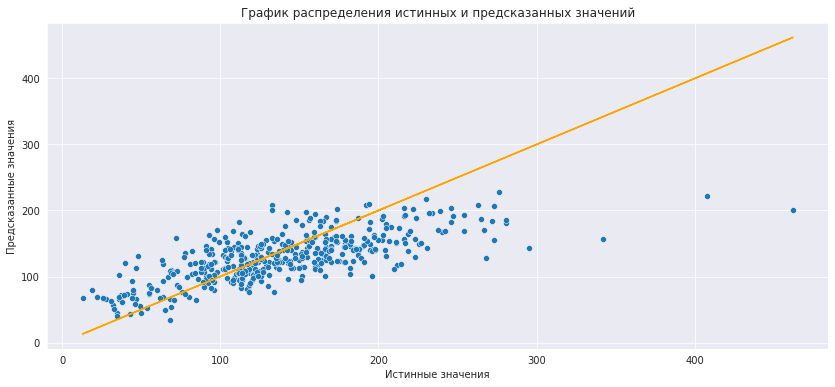

In [82]:
print('                          ГРАФИК РАССЕЯНИЯ ДЛЯ АНАЛИЗА ТОЧНОСТИ ПРЕДСКАЗАНИЙ МОДЕЛИ                ')
print()
print()
plt.figure(figsize=(14,6))
sns.set_style('darkgrid')
sns.scatterplot(x=y_test, y=y_pred)
plt.plot(y_test, y_test, color='orange')
plt.title('График распределения истинных и предсказанных значений')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.show()

Построим визуализацию результатов (два временных ряда на одном графике - реальные тестовые значения и предсказанные моделью).

In [93]:
y_pred = pd.Series(y_pred, index=y_test.index)

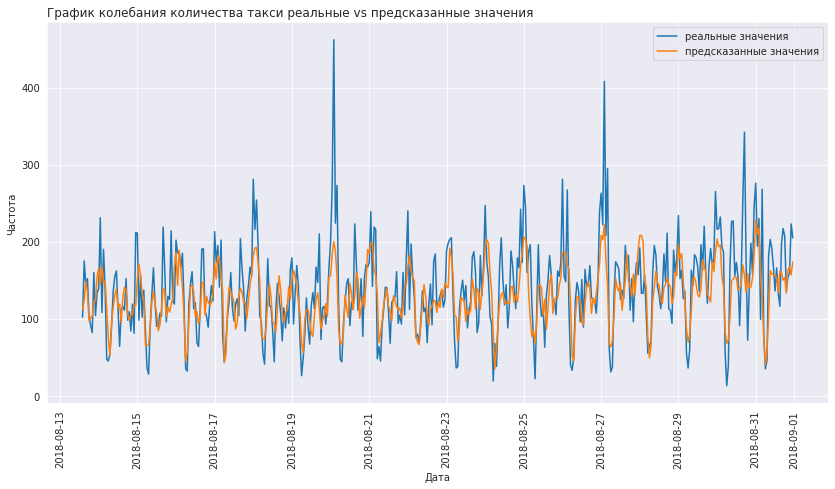

In [95]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=y_test, x=y_test.index, y=y_test, label='реальные значения')
sns.lineplot(data=y_pred, x=y_pred.index, y=y_pred, label='предсказанные значения')
plt.title('График колебания количества такси реальные vs предсказанные значения', loc = 'left') 
plt.xlabel('Дата') 
plt.ylabel('Частота') 
plt.xticks(rotation=90)
plt.show()

**Промежуточный вывод**

На тестовой выборке модель работает хуже. Но мы помним, что данные мы разбиваем в хронологическом порядке, соответственно тестовая выборка будет по новым по времени данным. А там, как мы помним наблюдается мягкий рост тренда и увеличение дисперсии и шума. Но тем не менее метрика на тестовой выборке удовлетворяет условиям заказчика.

Построили график визуализации разброса истинных и предсказанных значений. По идее, если модель хорошо предсказывает , то точки должны вытянуться в облачко под 45 градусов. В принципе эту картину и наблюдаем, за исключением выбросов. Мы применяли метрику RMSE, а мы помним, то при поиске модели по этой метрике, она старается подстроиться под выбросы. Но с другой стороны в тренировочной выборке выбросов не должно было быть. Выбросы у нас начались в конце временного интервала. 

Затем построили визуализацию реального временного ряда и предсказанного. В целом модель неплохо отработала, за исключением выбросов, но также видим, что есть промежутки, где она усредняет данные. Например, как на этом участке.

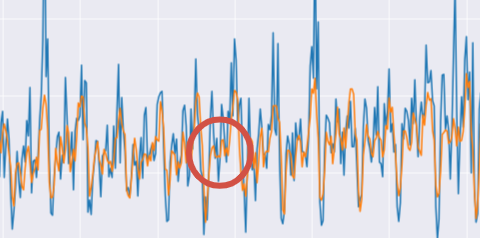

Вывод - модель стоит обучить на более полном наборе данных с учетом всплесков в конце августа и возможно с другой метрикой, чтобы модель не подстроилась под выбросы.

В целом модель оправдала пожелания заказчика.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48